In [ ]:
%pip install matplotlib
%pip install seaborn
%pip install emoji
%pip install nltk
%pip install wordcloud
%pip install scikit-learn
%pip install nlpaug
%pip install tensorflow
%pip install tf-keras

import nltk
nltk.download('wordnet')

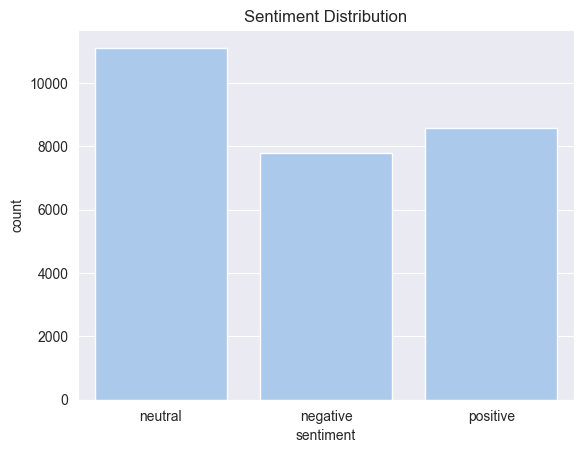

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Epoch 1/10
687/687 [==============================] - 2772s 4s/step - loss: 1.1524 - accuracy: 0.3938 - val_loss: 1.0782 - val_accuracy: 0.4299
Epoch 2/10
687/687 [==============================] - 2765s 4s/step - loss: 1.0769 - accuracy: 0.4114 - val_loss: 1.0514 - val_accuracy: 0.4554
Epoch 3/10
687/687 [==============================] - 2760s 4s/step - loss: 0.9724 - accuracy: 0.5372 - val_loss: 0.7942 - val_accuracy: 0.7021
Epoch 4/10
687/687 [==============================] - 2762s 4s/step - loss: 0.7927 - accuracy: 0.7137 - val_loss: 0.7409 - val_accuracy: 0.7373
Epoch 5/10
687/687 [==============================] - 2762s 4s/step - loss: 0.7308 - accuracy: 0.7546 - val_loss: 0.7089 - val_accuracy: 0.7591
Epoch 6/10
687/687 [==============================] - 2755s 4s/step - loss: 0.7001 - accuracy: 0.7719 - val_loss: 0.6932 - val_accuracy: 0.7636
Epoch 7/10
687/687 [==============================] - 2751s 4s/step - loss: 0.6742 - accuracy: 0.7919 - val_loss: 0.6845 - val_accuracy:

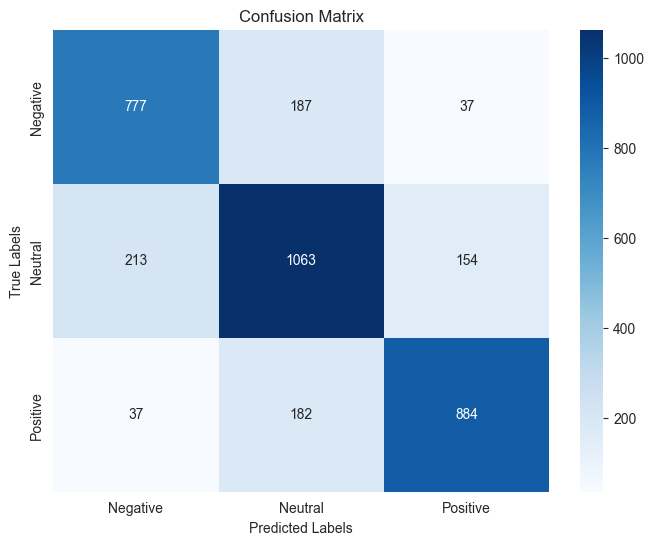

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from transformers import AlbertTokenizer, TFAlbertModel, AdamWeightDecay
import string

# Seaborn Style
sns.set_palette('pastel')
sns.set_style('darkgrid')

# Load Data
train_df = pd.read_csv('train.csv').dropna()
test_df = pd.read_csv('test.csv').dropna()

# Visualize Sentiment Distribution
sns.countplot(data=train_df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()

sentiment_classes = train_df['sentiment'].unique()

# Preprocessing Function
LEMMATIZER = WordNetLemmatizer()
URL_PATTERN = re.compile(r"http[s]?://\S+|www\.\S+")
EMAIL_PATTERN = re.compile(r"\S+@\S+")
HASH_PATTERN = re.compile(r"#(\w+)")
HANDLE_PATTERN = re.compile(r"@\w+")
REPEAT_PATTERN = re.compile(r"([A-Za-z])\1{2,}")
NUM_PATTERN = re.compile(r"[0-9]")
PUNC_PATTERN = re.compile(f"[{re.escape(string.punctuation)}]")

# Selective Stopword Removal
KEY_STOPWORDS = {'not', 'no', 'nor', 'only'}

def preprocess_text(text):
    text = re.sub(URL_PATTERN, '', text)
    text = re.sub(EMAIL_PATTERN, '', text)
    text = re.sub(HASH_PATTERN, r'\1', text)
    text = re.sub(HANDLE_PATTERN, '', text)
    text = emoji.demojize(text)
    text = re.sub(REPEAT_PATTERN, r'\1', text)
    text = re.sub(NUM_PATTERN, ' ', text)
    text = re.sub(PUNC_PATTERN, ' ', text)
    text = text.lower()
    words = [LEMMATIZER.lemmatize(word) for word in text.split() if word not in KEY_STOPWORDS]
    return " ".join(words)

# Apply Preprocessing
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)
train_df['cleaned_text'] = train_df['cleaned_text'].astype(str)
test_df['cleaned_text'] = test_df['cleaned_text'].astype(str)

# Tokenization
max_length = 128
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

def encode_texts(texts, max_length=128):
    encodings = tokenizer(texts, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf')
    return encodings['input_ids'], encodings['attention_mask']

X_train_ids, X_train_attention = encode_texts(train_df['cleaned_text'].tolist())
X_test_ids, X_test_attention = encode_texts(test_df['cleaned_text'].tolist())

def build_model():
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
    albert_model = TFAlbertModel.from_pretrained("albert-base-v2")
    for layer in albert_model.layers:
        layer.trainable = True
    albert_output = albert_model(input_ids, attention_mask=attention_mask)[0]
    cls_output = tf.keras.layers.GlobalMaxPooling1D()(albert_output)
    dropout = tf.keras.layers.Dropout(0.2)(cls_output)  # Increased dropout to 0.4
    output = tf.keras.layers.Dense(3, activation='softmax')(dropout)
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the Model
albert_model = build_model()
albert_model.compile(
     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True
)

# Train the Model
history = albert_model.fit(
    [X_train_ids, X_train_attention], np.array(pd.get_dummies(train_df['sentiment']).values),
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[early_stopping]
)

# Evaluate the Model
y_test = np.array(pd.get_dummies(test_df['sentiment']).values)
y_pred_probs = albert_model.predict([X_test_ids, X_test_attention])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()


